In [123]:
import numpy as np
import os
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [124]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Flatten, BatchNormalization, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [125]:
np.random.seed(34)

In [126]:
## Checking the GPU configuration
!nvidia-smi

import tensorflow as tf

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

Sat Mar 16 04:10:01 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   62C    P8     4W /  N/A |   2830MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [127]:
train_doc = np.random.permutation(open('./train_4.csv').readlines())
val_doc = np.random.permutation(open('./val_4.csv').readlines())
data_path = './dataset_aug'
gesture_num = 6

In [128]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [129]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [130]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size, gesture_num)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        vid = t[folder + (batch*batch_size)].strip().split(',')
        vid_path = os.path.join(source_path, os.path.join(vid[1], vid[0]))
        imgs = os.listdir(vid_path) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
#             print("idx: ", idx)
#             print("item: ",item)
            image = imread(os.path.join(vid_path, imgs[item])).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = normalizeImage(image[:, :, 0])
            batch_data[folder,idx,:,:,1] = normalizeImage(image[:, :, 1])
            batch_data[folder,idx,:,:,2] = normalizeImage(image[:, :, 2])

#         print("folder: ", folder)
#         print("index:  ", int(t[folder + (batch*batch_size)].strip().split(',')[2]))
        batch_labels[folder, int(vid[2])] = 1
    return batch_data, batch_labels

In [131]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

In [132]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 90, 160, 3]

In [133]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [134]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 960
# validation sequences = 240


In [135]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

# callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

In [136]:
n_frames = 15
num_epochs = 30
batch_size = 8

img_tensor = getImgTensor(n_frames)
train_generator = generator(data_path, train_doc, batch_size, img_tensor)
val_generator = generator(data_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(gesture_num, activation='softmax')
], name="conv_3d1")
model1.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_39 (Conv3D)          (None, 11, 86, 156, 16)   6016      
                                                                 
 max_pooling3d_39 (MaxPoolin  (None, 6, 43, 78, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_65 (Bat  (None, 6, 43, 78, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_40 (Conv3D)          (None, 4, 41, 76, 32)     13856     
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 4, 21, 38, 32)    0         
 g3D)                                                            
                                                          

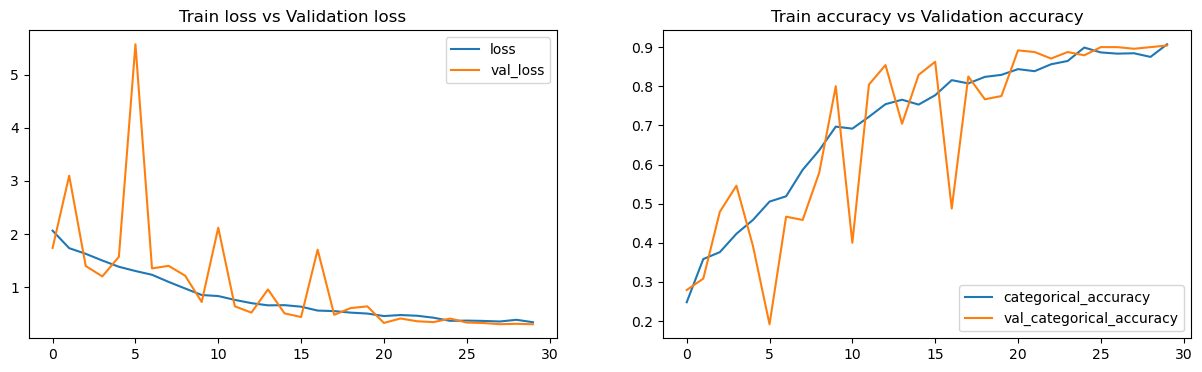

Max. Training Accuracy 0.9072916507720947
Max. Validaiton Accuracy 0.9041666388511658


In [137]:
plotModelHistory(model1_history)

In [138]:
n_frames = 30
num_epochs = 30
batch_size = 8

img_tensor = getImgTensor(n_frames)
train_generator = generator(data_path, train_doc, batch_size, img_tensor)
val_generator = generator(data_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(gesture_num, activation='softmax')
], name="conv_3d2")
model2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_42 (Conv3D)          (None, 26, 86, 156, 16)   6016      
                                                                 
 max_pooling3d_42 (MaxPoolin  (None, 13, 43, 78, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_70 (Bat  (None, 13, 43, 78, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_43 (Conv3D)          (None, 11, 41, 76, 32)    13856     
                                                                 
 max_pooling3d_43 (MaxPoolin  (None, 11, 21, 38, 32)   0         
 g3D)                                                            
                                                          

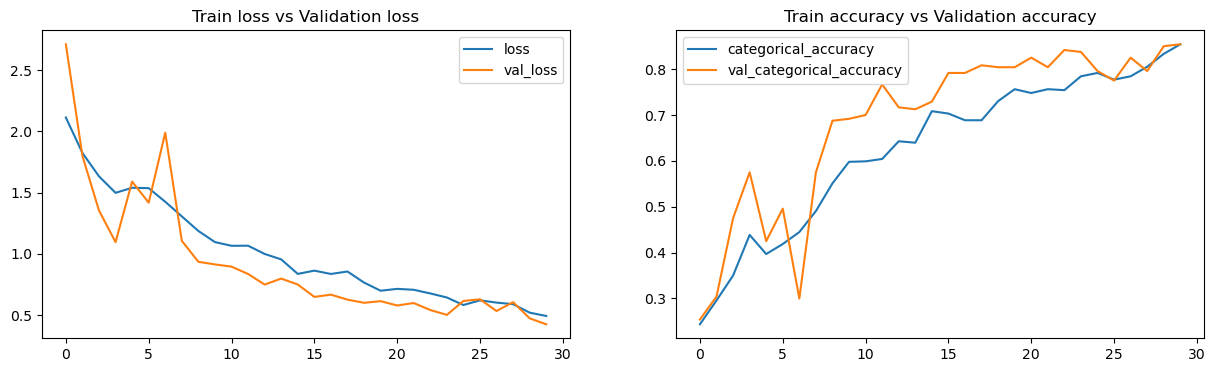

Max. Training Accuracy 0.8541666865348816
Max. Validaiton Accuracy 0.8541666865348816


In [139]:
plotModelHistory(model2_history)

Source path =  ./dataset_aug ; batch size = 8
(8, 30, 90, 160, 3)
Source path =  ./dataset_aug ; batch size = 8
(8, 30, 90, 160, 3)


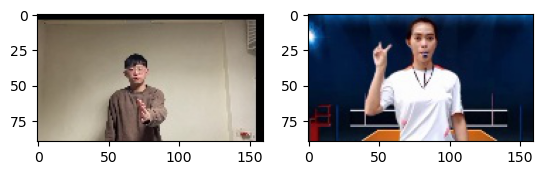

In [140]:
# check complete batch shape
sample_generator = generator(data_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(data_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[0,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[7,10,:,:,:])
plt.show()